<a href="https://colab.research.google.com/github/nhjung-phd/Papers/blob/main/factor2025/factor_rl_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shimmy>=0.2.1

In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

# 첫 번째 실험 (PPO + Crypto + Sharpe 보상)

다음 6가지 실험을 한 번에 실행하고 결과를 비교

Crypto_PPO_sharpe

Crypto_PPO_beta

Crypto_SAC_sharpe

Crypto_SAC_beta

Crypto_TD3_sharpe

Crypto_TD3_beta

In [ ]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Asset Group
crypto_assets = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]

# Data
def fetch_data(assets, start="2019-01-01", end="2024-12-31"):
    data = yf.download(assets, start=start, end=end)["Close"]
    price = data.dropna()
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20)
    volatility = returns.rolling(20).std()
    factors = pd.concat([momentum.add_suffix("_mom"), volatility.add_suffix("_vol")], axis=1).dropna()
    idx = returns.index.intersection(factors.index)
    return price.loc[idx], returns.loc[idx], factors.loc[idx]

# Environment
class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super().__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 30
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.objective = objective
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.window, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current - self.window:self.current].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action /= (np.sum(action) + 1e-8)
        price_today = self.price.iloc[self.current].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value
        cost = np.sum(np.abs(trade_value) * 0.001)
        self.cash -= cost
        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)
        price_next = self.price.iloc[self.current + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - self.portfolio_value[-1]) / self.portfolio_value[-1]
        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current += 1
        done = self.current + 1 >= len(self.returns)
        obs = self.factors.iloc[self.current - self.window:self.current].values
        # 보상함수
        if self.objective == "sharpe":
            r = np.array(self.portfolio_returns[-30:])
            reward = np.mean(r) / (np.std(r) + 1e-6)
        elif self.objective == "beta":
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            reward = np.dot(action, beta_score)
        elif self.objective == "hybrid":
            r = np.array(self.portfolio_returns[-30:])
            sharpe = np.mean(r) / (np.std(r) + 1e-6)
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            beta = np.dot(action, beta_score)
            reward = 0.5 * sharpe + 0.5 * beta
        else:
            reward = port_return
        return obs, reward, done, {"portfolio_value": port_value_next}

# Training & Evaluation
def train_and_evaluate(assets, algo_class, objective="sharpe"):
    price, returns, factors = fetch_data(assets)
    def make_env():
        return PPOPortfolioEnv(returns, factors, price, objective)
    env = DummyVecEnv([make_env])
    model = algo_class("MlpPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=50000)

    # 평가 시뮬레이션
    env_eval = make_env()
    obs = env_eval.reset()
    values = []
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = env_eval.step(action)
        values.append(info["portfolio_value"])
        if done:
            break
    index = price.index[31:31+len(values)]
    return pd.Series(values, index=index)

# 성과 계산
# 성과 지표 계산
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    cagr = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.0) / (annualized_vol + 1e-6)
    downside_std = returns[returns < 0].std() * np.sqrt(252)
    sortino = (cagr - 0.0) / (downside_std + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    turnover = (np.abs(returns).sum()) / len(returns)
    return {
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Cumulative Return": cumulative_return,
        "Annualized Return": cagr,
        "Annualized Volatility": annualized_vol,
        "CAGR": cagr,
        "Maximum Drawdown": mdd,
        "Turnover Ratio": turnover
    }

# 실험 실행
experiments = [
    ("Crypto", crypto_assets, "PPO", PPO, "sharpe"),
    ("Crypto", crypto_assets, "PPO", PPO, "beta"),
    ("Crypto", crypto_assets, "PPO", PPO, "hybrid"),
    ("Crypto", crypto_assets, "SAC", SAC, "sharpe"),
    ("Crypto", crypto_assets, "SAC", SAC, "beta"),
    ("Crypto", crypto_assets, "SAC", SAC, "hybrid"),
    ("Crypto", crypto_assets, "TD3", TD3, "sharpe"),
    ("Crypto", crypto_assets, "TD3", TD3, "beta"),
    ("Crypto", crypto_assets, "TD3", TD3, "hybrid")
]

results = {}
for group, assets, algo_name, algo_class, objective in experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    results[key] = train_and_evaluate(assets, algo_class, objective)

# 성과 테이블 생성
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in results.items()}).T
print(metrics_table)

# 성과 막대 그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Crypto Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 포트폴리오 가치 통합 시계열 그래프
results_df = pd.DataFrame(results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison: Crypto + PPO/SAC/TD3 + Sharpe/Beta/Hybrid")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


▶ Running: Crypto_PPO_sharpe
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Crypto_PPO_beta



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Crypto_SAC_sharpe



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


KeyboardInterrupt: 

Stock_PPO_sharpe

Stock_PPO_beta

Stock_SAC_sharpe

Stock_SAC_beta

Stock_TD3_sharpe

Stock_TD3_beta

In [ ]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# Seed 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 자산군 설정
stock_assets = ["AAPL", "MSFT", "GOOGL", "AMZN"]

# 데이터 수집 함수
def fetch_data(assets, start="2019-01-01", end="2024-12-31"):
    data = yf.download(assets, start=start, end=end)["Close"]
    price = data.dropna()
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20)
    volatility = returns.rolling(20).std()
    factors = pd.concat([momentum.add_suffix("_mom"), volatility.add_suffix("_vol")], axis=1).dropna()
    idx = returns.index.intersection(factors.index)
    return price.loc[idx], returns.loc[idx], factors.loc[idx]

# 강화학습 환경
class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super().__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 30
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.objective = objective
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.window, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current - self.window:self.current].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action /= (np.sum(action) + 1e-8)
        price_today = self.price.iloc[self.current].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value
        cost = np.sum(np.abs(trade_value) * 0.001)
        self.cash -= cost
        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)
        price_next = self.price.iloc[self.current + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - self.portfolio_value[-1]) / self.portfolio_value[-1]
        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current += 1
        done = self.current + 1 >= len(self.returns)
        obs = self.factors.iloc[self.current - self.window:self.current].values
        # 보상함수
        if self.objective == "sharpe":
            r = np.array(self.portfolio_returns[-30:])
            reward = np.mean(r) / (np.std(r) + 1e-6)
        elif self.objective == "beta":
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            reward = np.dot(action, beta_score)
        elif self.objective == "hybrid":
            r = np.array(self.portfolio_returns[-30:])
            sharpe = np.mean(r) / (np.std(r) + 1e-6)
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            beta = np.dot(action, beta_score)
            reward = 0.5 * sharpe + 0.5 * beta
        else:
            reward = port_return
        return obs, reward, done, {"portfolio_value": port_value_next}

# 훈련 및 평가 함수
def train_and_evaluate(assets, algo_class, objective="sharpe"):
    price, returns, factors = fetch_data(assets)
    def make_env():
        return PPOPortfolioEnv(returns, factors, price, objective)
    env = DummyVecEnv([make_env])
    model = algo_class("MlpPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=50000)

    # 평가
    env_eval = make_env()
    obs = env_eval.reset()
    values = []
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = env_eval.step(action)
        values.append(info["portfolio_value"])
        if done:
            break
    index = price.index[31:31+len(values)]
    return pd.Series(values, index=index)

# 성과 지표 계산
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    cagr = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.0) / (annualized_vol + 1e-6)
    downside_std = returns[returns < 0].std() * np.sqrt(252)
    sortino = (cagr - 0.0) / (downside_std + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    turnover = (np.abs(returns).sum()) / len(returns)
    return {
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Cumulative Return": cumulative_return,
        "Annualized Return": cagr,
        "Annualized Volatility": annualized_vol,
        "CAGR": cagr,
        "Maximum Drawdown": mdd,
        "Turnover Ratio": turnover
    }

# 실험 구성
experiments = [
    ("Stock", stock_assets, "PPO", PPO, "sharpe"),
    ("Stock", stock_assets, "PPO", PPO, "beta"),
    ("Stock", stock_assets, "PPO", PPO, "hybrid"),
    ("Stock", stock_assets, "SAC", SAC, "sharpe"),
    ("Stock", stock_assets, "SAC", SAC, "beta"),
    ("Stock", stock_assets, "SAC", SAC, "hybrid"),
    ("Stock", stock_assets, "TD3", TD3, "sharpe"),
    ("Stock", stock_assets, "TD3", TD3, "beta"),
    ("Stock", stock_assets, "TD3", TD3, "hybrid")
]

# 실험 실행
results = {}
for group, assets, algo_name, algo_class, objective in experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    results[key] = train_and_evaluate(assets, algo_class, objective)

# 성과 요약
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Stock Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 포트폴리오 가치 시계열 그래프 (겹침)
results_df = pd.DataFrame(results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison: Stock + PPO/SAC/TD3 + Sharpe/Beta/hybrid")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


[                       0%                       ]

▶ Running: Stock_PPO_sharpe


[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_PPO_beta



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_PPO_hybrid



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_SAC_sharpe



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_SAC_beta



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_SAC_hybrid



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_TD3_sharpe



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_TD3_beta



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
[*********************100%***********************]  4 of 4 completed

▶ Running: Stock_TD3_hybrid



/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-6-70cb7a215c57>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = series[-1] / series[0] - 1
<ipython-input-6-70cb7a215c57>:123: FutureWarning: Series.__getitem__ treating keys as positions is depreca

                  Sharpe Ratio  Sortino Ratio  Cumulative Return  \
Stock_PPO_sharpe      0.566411       0.764050           1.388696   
Stock_PPO_beta        0.753306       1.022272           2.089920   
Stock_PPO_hybrid      0.571346       0.772265           1.418295   
Stock_SAC_sharpe      1.118800       1.503250           3.835966   
Stock_SAC_beta        1.606099       2.263594           8.768031   
Stock_SAC_hybrid      0.981708       1.317072           3.069526   
Stock_TD3_sharpe      0.930826       1.253866           2.848275   
Stock_TD3_beta        2.051940       2.952206          14.835417   
Stock_TD3_hybrid      1.164095       1.679586           4.394405   

                  Annualized Return  Annualized Volatility      CAGR  \
Stock_PPO_sharpe           0.162415               0.286743  0.162415   
Stock_PPO_beta             0.215296               0.285801  0.215296   
Stock_PPO_hybrid           0.164892               0.288601  0.164892   
Stock_SAC_sharpe           0.31

KeyError: "['Max Drawdown'] not in index"

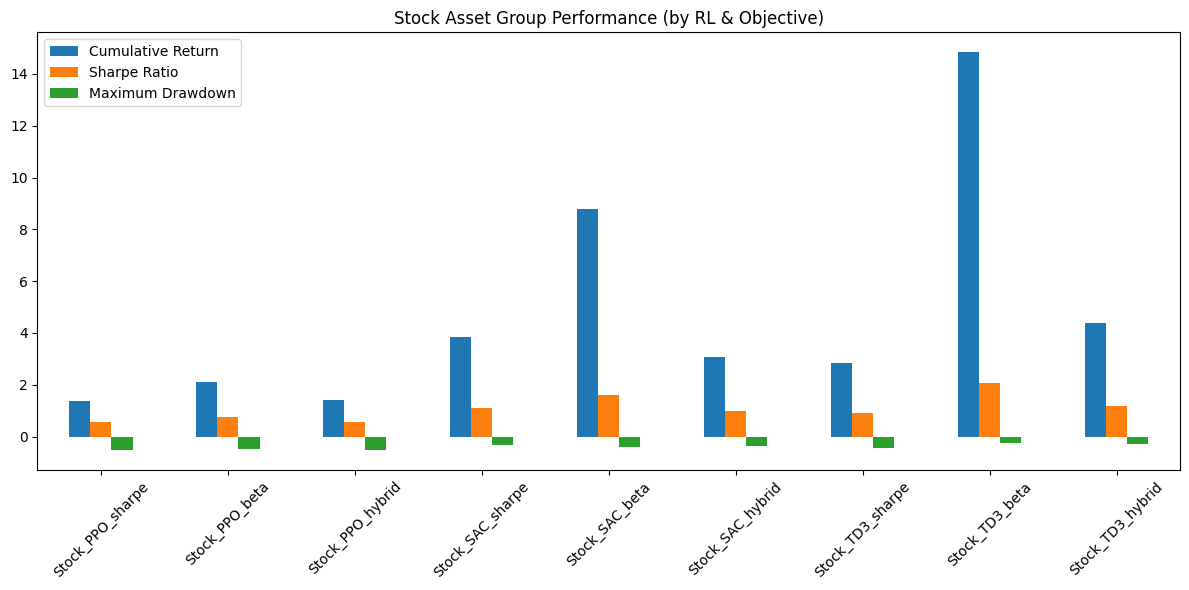

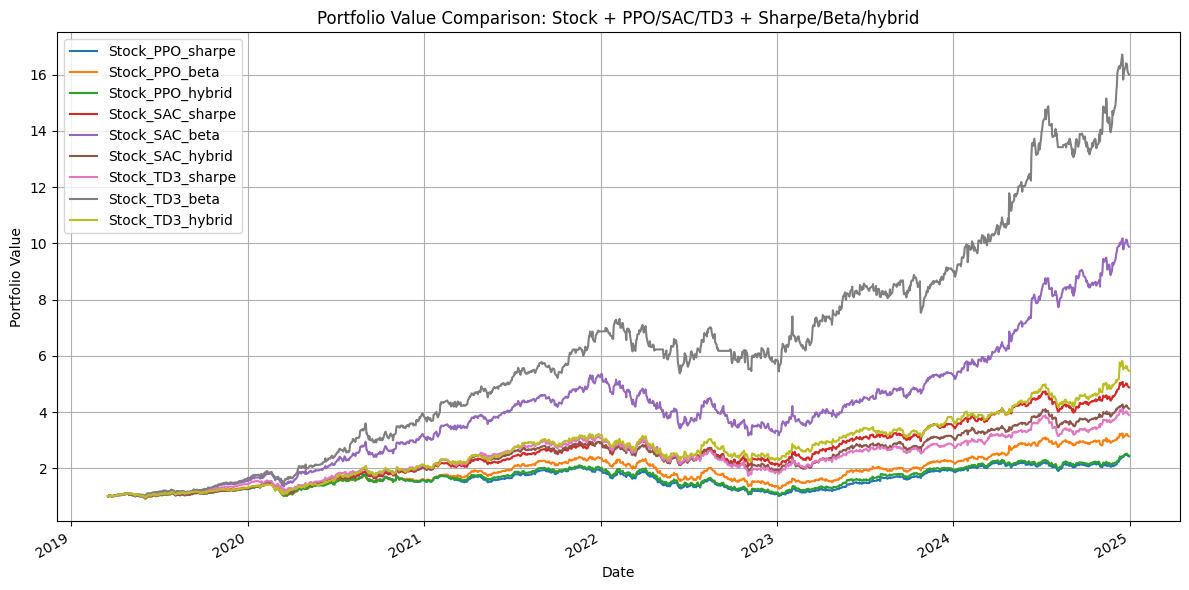

In [ ]:

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Stock Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 포트폴리오 가치 시계열 그래프 (겹침)
results_df = pd.DataFrame(results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison: Stock + PPO/SAC/TD3 + Sharpe/Beta/hybrid")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


# 전체 혼합 자산 기반 강화학습 포트폴리오 최적화 코드 (Sharpe, Beta, Hybrid 보상 포함)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.ensemble import GradientBoostingRegressor
import shap
import torch, random, gc

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 혼합 자산군
mixed_assets = ["BTC-USD", "ETH-USD", "AAPL", "MSFT", "GOOGL", "AMZN", "BNB-USD", "SOL-USD"]

# 데이터 함수
def fetch_data(assets, start="2019-01-01", end="2024-12-31"):
    data = yf.download(assets, start=start, end=end)
    price = data["Close"].dropna()
    volume = data["Volume"].dropna()
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20)
    volatility = returns.rolling(20).std()
    ma_deviation = (price - price.rolling(20).mean()) / price.rolling(20).mean()
    volume_zscore = (volume - volume.rolling(30).mean()) / volume.rolling(30).std()
    factors = pd.concat([
        momentum.add_suffix("_mom"),
        volatility.add_suffix("_vol"),
        ma_deviation.add_suffix("_ma"),
        volume_zscore.add_suffix("_volz")
    ], axis=1).dropna()
    idx = returns.index.intersection(factors.index)
    return price.loc[idx], returns.loc[idx], factors.loc[idx]

# 환경 정의
class PortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super().__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 30
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.objective = objective
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window, factors.shape[1]), dtype=np.float32)

    def reset(self):
        self.current = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current - self.window:self.current].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action /= (np.sum(action) + 1e-8)
        price_today = self.price.iloc[self.current].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value
        cost = np.sum(np.abs(trade_value) * 0.001)
        self.cash -= cost
        self.asset_quantity += trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today)

        price_next = self.price.iloc[self.current + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - self.portfolio_value[-1]) / self.portfolio_value[-1]
        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current += 1
        done = self.current + 1 >= len(self.returns)
        obs = self.factors.iloc[self.current - self.window:self.current].values

        # 보상함수
        if self.objective == "sharpe":
            r = np.array(self.portfolio_returns[-30:])
            reward = np.mean(r) / (np.std(r) + 1e-6)
        elif self.objective == "beta":
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            reward = np.dot(action, beta_score)
        elif self.objective == "hybrid":
            r = np.array(self.portfolio_returns[-30:])
            sharpe = np.mean(r) / (np.std(r) + 1e-6)
            beta_score = self.factors.iloc[self.current - 1][[a + "_mom" for a in self.assets if a + "_mom" in self.factors.columns]].values
            beta = np.dot(action, beta_score)
            reward = 0.5 * sharpe + 0.5 * beta
        else:
            reward = port_return

        return obs, reward, done, {"portfolio_value": port_value_next}

# 학습 및 평가
def train_and_evaluate(assets, algo_class, objective="sharpe"):
    price, returns, factors = fetch_data(assets)
    def make_env():
        return PortfolioEnv(returns, factors, price, objective)
    env = DummyVecEnv([make_env])
    model = algo_class("MlpPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=50000)

    env_eval = make_env()
    obs = env_eval.reset()
    values, states = [], []
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = env_eval.step(action)
        values.append(info["portfolio_value"])
        states.append(obs.flatten())
        if done:
            break
    index = price.index[31:31+len(values)]

    # SHAP 해석용 데이터
    shap_df = pd.DataFrame(states, columns=[f"F{i}" for i in range(len(states[0]))])
    gbm = GradientBoostingRegressor().fit(shap_df, values)
    explainer = shap.Explainer(gbm)
    shap_values = explainer(shap_df)
    shap.summary_plot(shap_values, shap_df, plot_type="bar")

    # 베타 유사 구조 시각화
    states = [env_eval.reset()]
    for _ in range(10):
        action, _ = model.predict(states[-1], deterministic=True)
        obs, _, done, _ = env_eval.step(action)
        if done:
            break
        states.append(obs)

    avg_actions = np.mean([model.predict(s, deterministic=True)[0] for s in states], axis=0)
    print("평균 Action (예시):", avg_actions)

    #avg_actions = np.mean([model.predict(s.reshape(1, *s.shape))[0] for s in states], axis=0)
    latest_factors = factors.iloc[-1][[a + "_mom" for a in price.columns if a in price.columns]]
    beta_exposure = pd.Series(avg_actions, index=price.columns[:len(avg_actions)]) * latest_factors.values
    beta_exposure.plot(kind="bar", title="Beta Exposure Structure (Momentum × Allocation)", figsize=(10, 4))
    plt.ylabel("Exposure Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 정리 및 리소스 해제
    del model
    gc.collect()

    return pd.Series(values, index=index)

# 성과 지표 계산
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series[-1] / series[0] - 1
    annualized_return = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    cagr = (series[-1] / series[0]) ** (252 / len(series)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.0) / (annualized_vol + 1e-6)
    downside_std = returns[returns < 0].std() * np.sqrt(252)
    sortino = (cagr - 0.0) / (downside_std + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    turnover = (np.abs(returns).sum()) / len(returns)
    return {
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Cumulative Return": cumulative_return,
        "Annualized Return": cagr,
        "Annualized Volatility": annualized_vol,
        "CAGR": cagr,
        "Maximum Drawdown": mdd,
        "Turnover Ratio": turnover
    }



# 실험 목록
experiments = [
    ("Mixed", mixed_assets, "PPO", PPO, "sharpe"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta"),
    ("Mixed", mixed_assets, "PPO", PPO, "hybrid"),
    ("Mixed", mixed_assets, "SAC", SAC, "sharpe"),
    ("Mixed", mixed_assets, "SAC", SAC, "beta"),
    ("Mixed", mixed_assets, "SAC", SAC, "hybrid"),
    ("Mixed", mixed_assets, "TD3", TD3, "sharpe"),
    ("Mixed", mixed_assets, "TD3", TD3, "beta"),
    ("Mixed", mixed_assets, "TD3", TD3, "hybrid"),
]

# 실행
results = {}
for group, assets, algo_name, algo_class, objective in experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    results[key] = train_and_evaluate(assets, algo_class, objective)


# 성과 요약
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Mixed Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 시각화
results_df = pd.DataFrame(results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison: Mixed Assets + PPO/SAC/TD3 + Sharpe/Beta/Hybrid")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()
